In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import gensim

In [3]:
df = pd.read_csv("food_review_cleaned.csv")
df.head()

,final_text,sentiment
0,shibunice service fast easy everything also fo...,0
1,excellent service amar singh next time expect ...,0
2,excellent excellenti first time kebab curry re...,0
3,according ambiance wanna give star restaurant ...,0
4,amazing place even better food geetika great h...,0


In [4]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df["final_text"],
                                                      df["sentiment"]  ,
                                                      stratify = df["sentiment"],
                                                      test_size=0.25,
                                                      random_state=42)
print(f"X_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_valid: {y_valid.shape}")

X_train: (7018,)
X_valid: (2340,)
y_train: (7018,)
y_valid: (2340,)


In [ ]:
X_train.head()

4723    definitely enjoable place jaipur good food goo...
278     love food excellent service excellent foodthe ...
7111    great food cute cosy ambience lot experimental...
6475    place amazing wonderful food awesome atmospher...
76      best place visit awesome placei ordered gatta ...
Name: final_text, dtype: object

In [ ]:
unique_words = []
for review in X_train:
  unique_words.extend(review.split())

len(set(unique_words))

In [ ]:
len(X_train.iloc[0].split())

17

In [ ]:
len_review = []
for review in X_train:
  len_review.append(len(review.split()))
len_series = pd.Series(data = len_review)
len_series.describe()

count    7018.000000
mean       16.254773
std        13.961594
min         1.000000
25%         6.000000
50%        13.000000
75%        20.000000
max        81.000000
dtype: float64

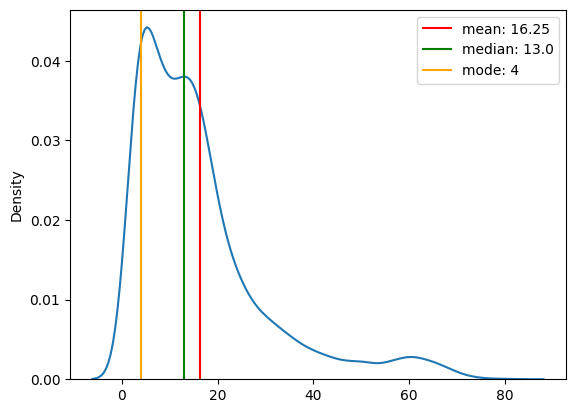

In [ ]:
sns.kdeplot(len_series)
plt.axvline(len_series.mean(), color = "red",
            label = f"mean: {round(len_series.mean(),2)}")
plt.axvline(len_series.median(), color = "green",
            label = f"median: {round(len_series.median(),2)}")
plt.axvline(len_series.mode()[0], color = "orange",
            label = f"mode: {round(len_series.mode()[0],2)}")
plt.legend()
plt.show()

In [ ]:
# Number of unique words in X_train
vocab = []
for review in X_train:
  vocab.extend(review.split())
len(set(vocab))

10795

In [ ]:
# Find average number of tokens (words) in training
sum([len(review.split()) for review in X_train])/len(X_train)

16.32744371615845

### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=10795, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=17, # how long should the output sequence of tokens be?
                                    pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = X_train.iloc[4]
print(sample_sentence)
list(text_vectorizer([sample_sentence]).numpy()[0])

best place visit awesome placei ordered gatta masala paneer delicious taking also helpful good


[15, 4, 16, 36, 2170, 24, 1142, 121, 41, 29, 535, 13, 188, 3, 0, 0, 0]

In [ ]:
text_vectorizer(["Food is mainly composed of water, lipids, proteins, and carbohydrates."])

<tf.Tensor: shape=(1, 17), dtype=int64, numpy=
array([[   2,    1, 1752,    1,    1,  228,    1,    1,    1,    1,    0,
           0,    0,    0,    0,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10728
Top 5 most common words: ['', '[UNK]', 'food', 'good', 'place']
Bottom 5 least common words: ['aagaya', 'aadiivaasii', 'aache', 'aabit', 'aaaaaaaaaaaaaaaaaaaaaaa']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [ ]:
corpus = []
for review in X_train:
  corpus.append(list(text_vectorizer([review]).numpy()[0]))

In [ ]:
corpus[:5]

In [ ]:
model = gensim.models.Word2Vec(
    vector_size = 128,
    window=2,
    min_count=0,
    sg=1
)

In [ ]:
model.build_vocab(corpus)

In [ ]:
model.corpus_count

7018

In [ ]:
model.train(corpus, total_examples=model.corpus_count, epochs=25)

(1778441, 2982650)

In [ ]:
len(text_vectorizer.get_vocabulary())

10728

In [ ]:
len(model.wv.key_to_index)

8381

In [ ]:
text_vectorizer.get_vocabulary()[10727]

'aaaaaaaaaaaaaaaaaaaaaaa'

In [ ]:
len(set(range(0, 10728)) - set(model.wv.key_to_index.keys()))

2347

In [ ]:
# to get word labels
model.wv.key_to_index.keys()

In [ ]:
# https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow

from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model,input_len = 17, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
        input_length = input_len
    )
    return layer

In [ ]:
embedding = gensim_to_keras_embedding(model)

In [ ]:
# Get a random sentence from training set
import random
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
ballokume cake unique delightful surprise arrived promptly auntic taste delightful twist traditional flavor highly satisfied      

Embedded version:


InvalidArgumentError: Exception encountered when calling layer 'embedding_2' (type Embedding).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,0] = 10243 is not in [0, 8381) [Op:ResourceGather] name: 

Call arguments received by layer 'embedding_2' (type Embedding):
  • inputs=tf.Tensor(shape=(1, 17), dtype=int64)

In [ ]:
from tensorflow.keras import layers

input = layers.Input(shape = (1,), dtype = "string")
tv = text_vectorizer(input)
ebd = embedding(tv)
ga = layers.GlobalAveragePooling1D()(ebd)
# d1 = layers.Dense(64, activation = "relu")(ga)
output = layers.Dense(1, activation = "sigmoid")(ga)

model = tf.keras.Model(inputs = input, outputs = output)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           1072768   
                                                                 
 global_average_pooling1d_7  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1072897 (4.09 MB)
Trainable params: 129 (516.

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

# train_sentences, val_sentences, train_labels, val_labels

model.fit(X_train, y_train, epochs = 5, validation_data = (X_valid, y_valid))

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node model_4/embedding_2/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-136-1c0f4d47eaf5>", line 9, in <cell line: 9>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[26,1] = 8860 is not in [0, 8381)
	 [[{{node model_4/embedding_2/embedding_lookup}}]] [Op:__inference_train_function_1044563]

## using tensorflow embedding layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=17) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True)
text_vectorizer.adapt(X_train)

In [ ]:
from tensorflow.keras.layers import Embedding
ebd_layer = Embedding(
    input_dim = len(text_vectorizer.get_vocabulary()),
    output_dim = 128,
    input_length = 17
)

In [ ]:
ebd_layer.get_weights()

[]

In [ ]:
input = tf.keras.layers.Input(shape = (1,), dtype= "string")
tv = text_vectorizer(input)
ebd = ebd_layer(tv)
ga = tf.keras.layers.GlobalAveragePooling1D()(ebd)
# d1 = tf.keras.layers.Dense(16, activation = "relu")(ga)
output = tf.keras.layers.Dense(1, activation = "sigmoid")(ga)

model_ebd = tf.keras.Model(inputs = input, outputs = output)
model_ebd.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 17, 128)           1373184   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1373313 (5.24 MB)
Trainable params: 1373313 (5.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras.layers import Embedding
ebd_layer = Embedding(
    input_dim = len(text_vectorizer.get_vocabulary()),
    output_dim = 128,
    input_length = 17
)
input = tf.keras.layers.Input(shape = (1,), dtype= "string")
tv = text_vectorizer(input)
ebd = ebd_layer(tv)
ga = tf.keras.layers.GlobalAveragePooling1D()(ebd)
# d1 = tf.keras.layers.Dense(16, activation = "relu")(ga)
output = tf.keras.layers.Dense(1, activation = "sigmoid")(ga)

model_ebd = tf.keras.Model(inputs = input, outputs = output)

model_ebd.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)
result_ebd = model_ebd.fit(X_train, y_train, epochs = 4, validation_data = (X_valid, y_valid))

Epoch 1/4
220/220 [==============================] - 8s 30ms/step - loss: 0.5217 - accuracy: 0.8064 - val_loss: 0.3567 - val_accuracy: 0.8932
Epoch 2/4
220/220 [==============================] - 7s 33ms/step - loss: 0.2752 - accuracy: 0.9243 - val_loss: 0.2493 - val_accuracy: 0.9137
Epoch 3/4
220/220 [==============================] - 6s 28ms/step - loss: 0.1978 - accuracy: 0.9413 - val_loss: 0.2215 - val_accuracy: 0.9201
Epoch 4/4
220/220 [==============================] - 7s 33ms/step - loss: 0.1607 - accuracy: 0.9527 - val_loss: 0.2157 - val_accuracy: 0.9265


In [ ]:
y_pred_ebd = model_ebd.predict(X_valid)
y_pred_ebd[:5]

74/74 [==============================] - 1s 8ms/step


array([[0.7269088 ],
       [0.95789844],
       [0.9569546 ],
       [0.16424981],
       [0.9655901 ]], dtype=float32)

In [ ]:
np.where(y_pred_ebd>=0.5, 1,0)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
y_pred_ebd_flat = np.round(y_pred_ebd).flatten()
y_pred_ebd_flat[:5]

array([1., 1., 1., 0., 1.], dtype=float32)

In [ ]:
y_valid[:5]

6741    1
5158    1
102     1
2167    1
1130    1
Name: sentiment, dtype: int64

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_valid, y_pred_ebd_flat))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1410
           1       0.91      0.90      0.91       930

    accuracy                           0.93      2340
   macro avg       0.92      0.92      0.92      2340
weighted avg       0.93      0.93      0.93      2340



In [ ]:
ebd_layer.get_weights()[0].shape

(10728, 128)

In [ ]:
ebd_layer.get_weights()[0]

array([[ 0.01263154,  0.0293316 , -0.15497628, ..., -0.0174331 ,
         0.04353785, -0.00564677],
       [ 0.02874495, -0.01914516, -0.01349318, ..., -0.03691667,
        -0.00544834, -0.02390745],
       [-0.01429861, -0.0186289 , -0.08695437, ..., -0.01681868,
         0.02060184,  0.0523543 ],
       ...,
       [ 0.03135248,  0.0109047 , -0.05246972, ...,  0.01060039,
         0.05443032, -0.06696039],
       [-0.06144397, -0.07442166,  0.01289961, ..., -0.04346159,
        -0.03248325,  0.05496817],
       [-0.02560253, -0.10185267, -0.09275164, ..., -0.0281708 ,
        -0.03331344,  0.01637252]], dtype=float32)

In [ ]:
import nltk
import re
# import emoji
import string
from nltk.stem import WordNetLemmatizer
nltk.download('popular')

In [ ]:
with open("sw_new.txt", "r") as f:
  sw_new = f.read()
sw_new = sw_new.split("\n")

In [ ]:
def text_cleaner(text, sw = sw_new):
  import nltk
  import re
  # import emoji
  import string
  from nltk.stem import WordNetLemmatizer

  # mobile_regex = "(\+*)((0[ -]*)*|((91 )*))((\d{12})+|(\d{10})+)|\d{5}([- ]*)\d{6}"
  url_regex = "((http|https|www)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
  space_regex = "\s\s+"
  # remove url
  text = re.sub(url_regex, "", text)
  # remove mobile
  # text = re.sub(mobile_regex, "", text)
  # lower casing
  text = text.lower()
  # remove emoji & punctuation & numbers
  text = "".join([i for i in text if (ord(i) in range(97,123)) | (i == " ")])
  # remove multiple spaces
  text = re.sub(space_regex, " ", text)

  # stopword removal
  text = [i for i in text.split() if i not in sw]
  # lemmatizing
  lemma = WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(i) for i in text])

  return text

In [ ]:
test = "I went here alone. They don't having table for one person. Overall I think any of the other restaurants in the same block would be better choice. I hered many times, the name of chhabra's from Jaipur guys. Terrible."
clean_text = text_cleaner(test)

In [ ]:
clean_text

'went alone dont table one person overall think restaurant block would better choice hered many time name chhabras jaipur guy terrible'

In [ ]:
model_ebd(tf.constant([clean_text]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8585447]], dtype=float32)>

In [ ]:
y_pred = model_ebd.predict(X_valid)

74/74 [==============================] - 1s 5ms/step


In [ ]:
from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 14
embedding = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize uniform
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
from tensorflow.keras import layers

input = layers.Input(shape = (1,), dtype = "string")
tv = text_vectorizer(input)
ebd = embedding(tv)
ga = layers.GlobalAveragePooling1D()(ebd)
# d1 = layers.Dense(64, activation = "relu")(ga)
output = layers.Dense(1, activation = "sigmoid")(ga)

In [ ]:
model = tf.keras.Model(inputs = input, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 17, 128)           1373184   
                                                                 
 global_average_pooling1d_6  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1373313 (5.24 MB)
Trainable params: 1373313 (

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

# train_sentences, val_sentences, train_labels, val_labels

model.fit(X_train, y_train, epochs = 5, validation_data = (X_valid, y_valid))

Epoch 1/5
220/220 [==============================] - 6s 23ms/step - loss: 0.5210 - accuracy: 0.7907 - val_loss: 0.3557 - val_accuracy: 0.8863
Epoch 2/5
220/220 [==============================] - 7s 30ms/step - loss: 0.2744 - accuracy: 0.9249 - val_loss: 0.2495 - val_accuracy: 0.9128
Epoch 3/5
220/220 [==============================] - 5s 21ms/step - loss: 0.1983 - accuracy: 0.9413 - val_loss: 0.2232 - val_accuracy: 0.9261
Epoch 4/5
220/220 [==============================] - 5s 22ms/step - loss: 0.1620 - accuracy: 0.9526 - val_loss: 0.2130 - val_accuracy: 0.9239
Epoch 5/5
220/220 [==============================] - 6s 27ms/step - loss: 0.1361 - accuracy: 0.9615 - val_loss: 0.2113 - val_accuracy: 0.9235


In [ ]:
y_pred = model.predict(X_valid)

74/74 [==============================] - 1s 6ms/step


In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score for class 1
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred)
  model_results = {"Accuracy": [np.round(model_accuracy,2)],
                  "Precision": [np.round(model_precision[1]* 100,2)],
                  "Recall": [np.round(model_recall[1]* 100,2)],
                  "F1_score": [np.round(model_f1[1]* 100,2)]}
  return model_results

In [ ]:
# Get baseline results
model_results = calculate_results(y_true=y_valid,
                                     y_pred=tf.round(y_pred_ebd))
model_results

{'Accuracy': [92.65],
 'Precision': [91.47],
 'Recall': [89.89],
 'F1_score': [90.67]}

In [ ]:
result_df = pd.DataFrame({
        "Description": [],
        "Precision": [],
        "Recall": [],
        "F1_score":[],
        "Accuracy":[],
        "Pred_time_in_seconds" : []
    })

In [ ]:
import time
def result_log(model,text,X_test, y_true,result_df):
  start_time = time.time()
  y_pred = model.predict(X_test)
  end_time = time.time()
  pred_time = end_time - start_time
  result_dict = calculate_results(y_true=y_valid,y_pred=tf.round(y_pred))
  result_dict["Description"] = text
  result_dict["Pred_time_in_seconds"] = [pred_time]
  temp_df = pd.DataFrame(data = result_dict)
  result_df = pd.concat([result_df, temp_df]).reset_index(drop = True)

  return result_df

In [ ]:
import joblib
model_nb = joblib.load("/content/food_review_nb.joblib")
model_nb

Pipeline(steps=[('bow', CountVectorizer()), ('nb', MultinomialNB())])

In [ ]:
result_df = result_log(model_nb,"naive bayes",X_valid, y_valid, result_df)
result_df

,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,92.3,91.51,91.9,93.59,0.062739


In [ ]:
result_df = result_log(model_ebd,"Embedding model",X_valid, y_valid, result_df)
result_df

74/74 [==============================] - 0s 3ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,92.30,91.51,91.90,93.59,0.062739
1,Embedding model,91.47,89.89,90.67,92.65,0.444840


In [ ]:
model_ebd.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           1373184   
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1373313 (5.24 MB)
Trainable params: 1373313 (

In [ ]:
model_ebd.get_layer("embedding_2").get_weights()[0]


array([[ 0.00078786,  0.03862884, -0.02060587, ..., -0.05303313,
        -0.0158234 ,  0.00964019],
       [-0.04069545, -0.04382602,  0.03401233, ..., -0.03506435,
        -0.02438623, -0.02539861],
       [-0.04033008, -0.10566339,  0.08823372, ..., -0.06425567,
         0.02271944, -0.04051538],
       ...,
       [ 0.080149  ,  0.03647736, -0.0055267 , ...,  0.0278871 ,
        -0.00515597, -0.00054996],
       [-0.07899558, -0.03774323,  0.02311277, ..., -0.02787532,
         0.0564464 , -0.08206172],
       [-0.01346026, -0.10781498,  0.02717843, ..., -0.01726723,
         0.0890526 , -0.01875919]], dtype=float32)

In [ ]:
embed_weights = model_ebd.get_layer("embedding_2").get_weights()[0]
print(embed_weights.shape)

(10728, 128)


Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding.

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

In [ ]:
text_vacorizer.get

In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")
words_in_vocab = text_vectorizer.get_vocabulary()
# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 17

model_1_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create rnn model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_1_embedding(x)
# print(x.shape)
x = layers.Dropout(0.2)(x)
x = layers.SimpleRNN(4, return_sequences=True, dropout = 0.2, kernel_regularizer='l1')(x) # return vector for whole sequence
# x = layers.SimpleRNN(8, return_sequences=True, dropout = 0.4, kernel_regularizer='l1')(x)
x = layers.SimpleRNN(4, dropout = 0.2, kernel_regularizer='l1')(x)
# print(x.shape)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_RNN")
model_1.summary()

Model: "model_1_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           1373184   
                                                                 
 dropout_12 (Dropout)        (None, 17, 128)           0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 17, 4)             532       
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 4)                 36        
                                                       

In [ ]:
tf.random.set_seed(42)
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
                metrics=["accuracy"])

# Fit model
model_1_history = model_1.fit(X_train,
                              y_train,
                              epochs=6,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/6
220/220 [==============================] - 11s 39ms/step - loss: 0.9914 - accuracy: 0.7747 - val_loss: 0.6972 - val_accuracy: 0.9034
Epoch 2/6
220/220 [==============================] - 7s 31ms/step - loss: 0.5858 - accuracy: 0.9121 - val_loss: 0.4897 - val_accuracy: 0.8970
Epoch 3/6
220/220 [==============================] - 8s 35ms/step - loss: 0.4185 - accuracy: 0.9298 - val_loss: 0.4045 - val_accuracy: 0.9026
Epoch 4/6
220/220 [==============================] - 12s 57ms/step - loss: 0.3471 - accuracy: 0.9387 - val_loss: 0.3788 - val_accuracy: 0.9000
Epoch 5/6
220/220 [==============================] - 10s 47ms/step - loss: 0.3037 - accuracy: 0.9466 - val_loss: 0.3738 - val_accuracy: 0.8927
Epoch 6/6
220/220 [==============================] - 7s 33ms/step - loss: 0.2702 - accuracy: 0.9560 - val_loss: 0.3562 - val_accuracy: 0.8932


In [ ]:
result_df = result_log(model_1,"rnn model",X_valid, y_valid, result_df)
result_df

74/74 [==============================] - 1s 4ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,92.30,91.51,91.90,93.59,0.062739
1,Embedding model,91.47,89.89,90.67,92.65,0.444840
2,rnn model,86.96,86.02,86.49,89.32,0.734767


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(8, return_sequences=True, dropout = 0.4, kernel_regularizer='l1')(x) # return vector for whole sequence
x = layers.LSTM(8)(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
model_2.summary()

(None, 17, 128)
(None, 8)
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 17)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           1373184   
                                                                 
 lstm_22 (LSTM)              (None, 17, 8)             4384      
                                                                 
 lstm_23 (LSTM)              (None, 8)                 544       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                            

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=2,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/2
220/220 [==============================] - 13s 42ms/step - loss: 1.6170 - accuracy: 0.8185 - val_loss: 0.3234 - val_accuracy: 0.9030
Epoch 2/2
220/220 [==============================] - 8s 35ms/step - loss: 0.2551 - accuracy: 0.9293 - val_loss: 0.2645 - val_accuracy: 0.9111


In [ ]:
result_df = result_log(model_2,"lstm model",X_valid, y_valid, result_df)
result_df

74/74 [==============================] - 3s 9ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,92.30,91.51,91.90,93.59,0.062739
1,Embedding model,91.47,89.89,90.67,92.65,0.444840
2,rnn model,86.96,86.02,86.49,89.32,0.734767
3,lstm model,89.58,87.85,88.71,91.11,4.054668


In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2") # load Universal Sentence Encoder
embed_samples = embed(["When you call the universal sentence encoder on a sentence" ,"it turns it into numbers."])

print(embed_samples)

tf.Tensor(
[[ 0.06244392 -0.05404239 -0.01550858 ... -0.01991867  0.03076827
   0.00064757]
 [-0.03539826 -0.09636232 -0.00950034 ... -0.02322183  0.01694256
  -0.0294972 ]], shape=(2, 512), dtype=float32)


In [ ]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [5]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
import tensorflow_hub as hub
from tensorflow.keras import layers
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [6]:
# Create model using the Sequential API

import tensorflow as tf
model_3 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_3_USE")

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0008),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [7]:
# Train a classifier on top of pretrained embeddings

model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=4,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/4
220/220 [==============================] - 9s 27ms/step - loss: 0.3445 - accuracy: 0.8770 - val_loss: 0.2157 - val_accuracy: 0.9218
Epoch 2/4
220/220 [==============================] - 4s 18ms/step - loss: 0.1951 - accuracy: 0.9317 - val_loss: 0.1995 - val_accuracy: 0.9239
Epoch 3/4
220/220 [==============================] - 7s 30ms/step - loss: 0.1835 - accuracy: 0.9367 - val_loss: 0.1957 - val_accuracy: 0.9235
Epoch 4/4
220/220 [==============================] - 9s 39ms/step - loss: 0.1775 - accuracy: 0.9386 - val_loss: 0.1990 - val_accuracy: 0.9226


In [ ]:
result_df = result_log(model_3,"use model",X_valid, y_valid, result_df)
result_df

74/74 [==============================] - 10s 61ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,92.30,91.51,91.90,93.59,0.062739
1,Embedding model,91.47,89.89,90.67,92.65,0.444840
2,rnn model,86.96,86.02,86.49,89.32,0.734767
3,lstm model,89.58,87.85,88.71,91.11,4.054668
4,use model,90.59,91.08,90.83,92.69,10.893819


## Save use model

In [8]:
tf.saved_model.save(model_3, "/content/drive/MyDrive/Imarticus/pga-04/08 DL/nlp/nlp_project/models/food_review_use_model")

In [ ]:
def prediction(text, model):
  text = text_cleaner(text)
  y_pred = model.predict([text])
  print(("Negative Review" if y_pred[0] == 1 else "Positive Review"))

In [ ]:
model_nb = joblib.load("/content/food_review_nb.joblib")

In [ ]:
text1 = "atmosphere is ok but food is not good"
text2 = "atmosphere is ok but food is bad"

In [ ]:
review = '''
Let's review all things step by step

Food - we went here after hearing this restaurant's name from many people. But food was quite average. In fact taste at "La multigrain" was better. We ordered red sauce paste and their pizza. Taste was quite okay. 3/5

Service - service was good. Person who was managing our orders asked us to tell them if something is not good in taste or any other issue so they can replace that. Hospitality was good.
4.5/5

Ambience - there are two types of sitting area. One is balcony and second is inside room. Restaurant has retro theme. Like retro bombay feel. You can enjoy old music here.
'''
prediction(review, model_nb)

Negative Review


In [ ]:
prediction(text2, model_nb)

Negative Review


In [ ]:
prediction(text1, model_3)

1/1 [==============================] - 2s 2s/step
Positive Review


In [ ]:
prediction(text2, model_3)

1/1 [==============================] - 0s 65ms/step
Positive Review


In [ ]:
text = text_cleaner(text1)
model_3.predict([text])

1/1 [==============================] - 0s 251ms/step


array([[0.90364265]], dtype=float32)

In [ ]:
text = text_cleaner('''
Very nice place if you are visiting Jaipur.
Way of presentation is way different.
We tried Jinni Dosa - Manchurian, Uttapam, Bombay Sandwich. All were very delicious and can be tried depending on individual likings.
''')
model_3.predict([text])

1/1 [==============================] - 0s 144ms/step


array([[0.00899538]], dtype=float32)

In [ ]:
! zip -r use.zip /content/food_review_use_model

  adding: content/food_review_use_model/ (stored 0%)
  adding: content/food_review_use_model/variables/ (stored 0%)
  adding: content/food_review_use_model/variables/variables.index (deflated 78%)
  adding: content/food_review_use_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/food_review_use_model/saved_model.pb (deflated 67%)
  adding: content/food_review_use_model/fingerprint.pb (stored 0%)
  adding: content/food_review_use_model/assets/ (stored 0%)
